In [1]:
import os
import numpy as np
import sep
import seaborn 
import pandas as pd
from astropy.io import fits
from astropy.io import ascii
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
%matplotlib inline

In [3]:
data_path = os.path.abspath('/home/bos0109/sersic/work/rhino/data/extract_test/stellar/CSTAR/')

In [4]:
images_path = os.path.join(data_path, 'images')
master_Ryan = os.path.join(images_path, 'master10_wcs.fits')

In [5]:
mR = fits.getdata(master_Ryan)

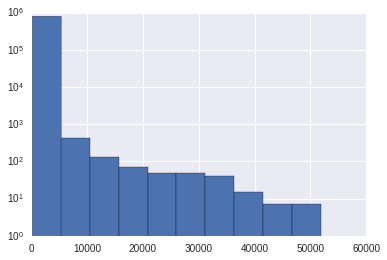

In [6]:
m2 = mR[mR > 0.]
plt.hist(m2.flatten(), log=True)

plt.show()

In [7]:
data = mR.byteswap().newbyteorder()

In [8]:
bkg = sep.Background(data)

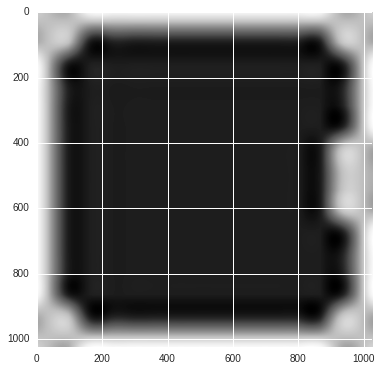

In [9]:
fig = plt.figure(figsize=(6,6))
plt.imshow(bkg.back())

In [10]:
img = data - bkg

In [11]:
import sep
sep.get_extract_pixstack()

300000

In [12]:
sep.set_extract_pixstack = 900000

In [13]:
sep.get_extract_pixstack()

300000

In [15]:
thresh = 11.*bkg.globalrms

sources = sep.extract(img, thresh)

In [16]:
obj = pd.DataFrame(sources)
print len(obj)

1315


In [17]:
stars = os.path.join(data_path, 'cats/stars.dat') 
stars = ascii.read(stars, names= ['cstarid','x','y','imag'])
stars = stars.to_pandas()
stars['objID'] = range(len(stars))

In [18]:
len(stars)

10241

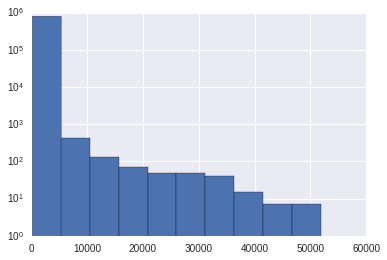

In [19]:
plt.hist(data[data > 0.].flatten(), log=True)
plt.show()

In [20]:
import astroML.crossmatch as cx

## Right

In [21]:
S = np.array([stars['x'], stars['y']]).T
O = np.array([obj['x'], obj['y']]).T

In [22]:
distr, indr  = cx.crossmatch(S, O, max_distance=1.5)

In [23]:
matchsr = ~np.isinf(distr)

## Left

In [24]:
distl, indl  = cx.crossmatch(O, S, max_distance=1.5)

In [25]:
matchsl = ~np.isinf(distl)

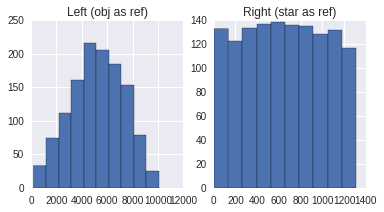

In [26]:
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.hist(indl[matchsl])
plt.title('Left (obj as ref)')
plt.subplot(122)
plt.hist(indr[matchsr])
plt.title('Right (star as ref)')
plt.show()

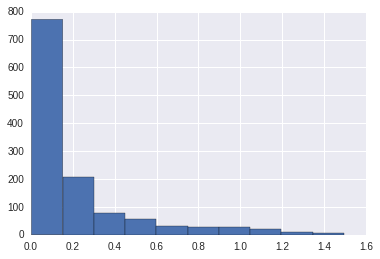

In [27]:
plt.hist(distl[matchsl].flatten())
plt.show()

Now the matchs are from left to **RIGHT**:
* matchs between the objects detected and stars in the catalog, using as reference *star catalog*.

right to **LEFT**
* matchs between stars in the catalog and objects using as reference *objects* detected

In [28]:
objID = np.zeros_like(O[:,0]) -1
CSTARID = np.zeros_like(O[:,0]) -1
for i in range(len(O)):
    if distl[i] != np.inf: 
        dist_o = distl[i]
        ind_o  = indl[i]
        # now ind is a star number
        # lets see if that star has matched the same obj
        if distr[ind_o] != np.inf:
            dist_s = distr[ind_o]
            ind_s = indr[ind_o]
            if ind_s == i:
                objID[i] = ind_o  
                CSTARID[i] = stars['cstarid'][ind_o]

In [29]:
obj['objID'] = objID
obj['cstarid'] = CSTARID

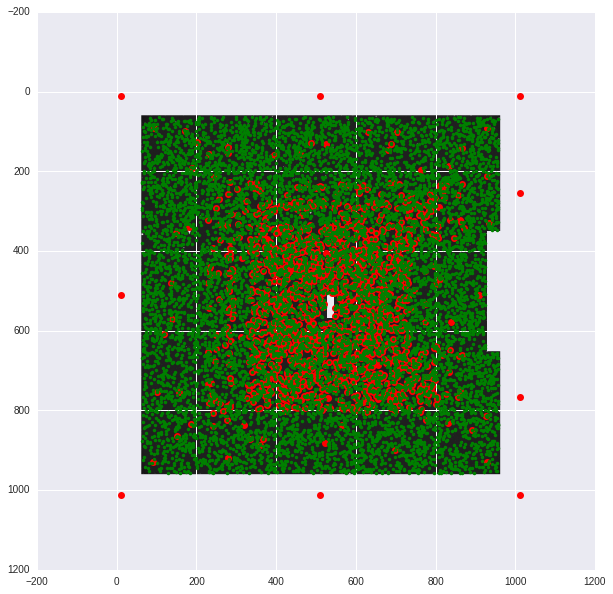

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(np.log10(data), cmap=cm.Greys_r)
f = obj['objID'] > 0
plt.plot(obj['x'], obj['y'], 'ro')
plt.plot(stars['x'], stars['y'], 'g.')


In [31]:
fake = obj[~f]
count = 0

In [41]:
for index in range(len(fake)):
    i = int(fake.reset_index()['x'][index])
    j = int(fake.reset_index()['y'][index])
    plt.imshow(np.log10(data), cmap=cm.Greys_r)
    plt.title('{}'.format(index))
    plt.plot(stars['x'], stars['y'], 'ob')
    plt.plot(i,j,'ro')
    plt.xlim(i-15,i+15)
    plt.ylim(j-15,j+15)
    plt.savefig('stamp_{}_{}.png'.format(i,j))
    plt.close()

In [33]:
print sum(objID > 0.), sum(objID < 0.)

1244 71


In [34]:
fake.columns

Index([u'thresh', u'npix', u'tnpix', u'xmin', u'xmax', u'ymin', u'ymax', u'x',
       u'y', u'x2', u'y2', u'xy', u'a', u'b', u'theta', u'cxx', u'cyy', u'cxy',
       u'cflux', u'flux', u'cpeak', u'peak', u'xcpeak', u'ycpeak', u'xpeak',
       u'ypeak', u'flag', u'objID', u'cstarid'],
      dtype='object')

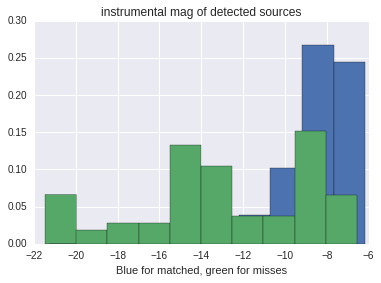

In [45]:
plt.hist(-2.5*np.log10(obj[f]['flux']), normed=True)#, cumulative=True)
plt.hist(-2.5*np.log10(fake['flux']), normed=True)#, cumulative=True)
plt.title('instrumental mag of detected sources')
plt.xlabel('Blue for matched, green for misses')
plt.show()

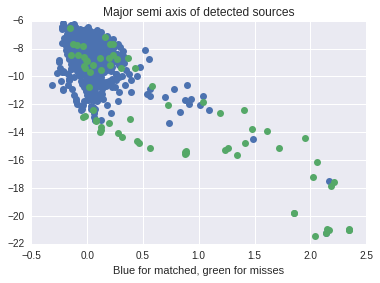

In [48]:
plt.plot(np.log10(obj[f]['a']), -2.5*np.log10(obj[f]['flux']), 'o')# normed=True, cumulative=True)
plt.plot(np.log10(fake['a']), -2.5*np.log10(fake['flux']), 'o')#,  normed=True, cumulative=True)
plt.title('Major semi axis of detected sources')
plt.xlabel('Blue for matched, green for misses')
plt.show()

In [68]:
stars_mag = np.asarray(stars['imag'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fc3ebb510>]], dtype=object)

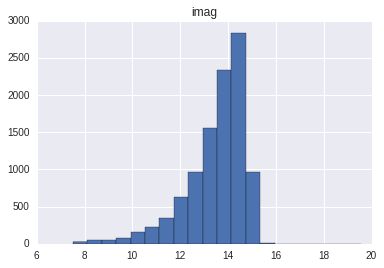

In [77]:
stars.hist(column='imag', bins=20)

In [79]:
mM = fits.getdata('../../../data/extract_test/master2010_masked_wcs.fits')
dataM = mM.byteswap().newbyteorder()

In [80]:
bkgM = sep.Background(dataM)

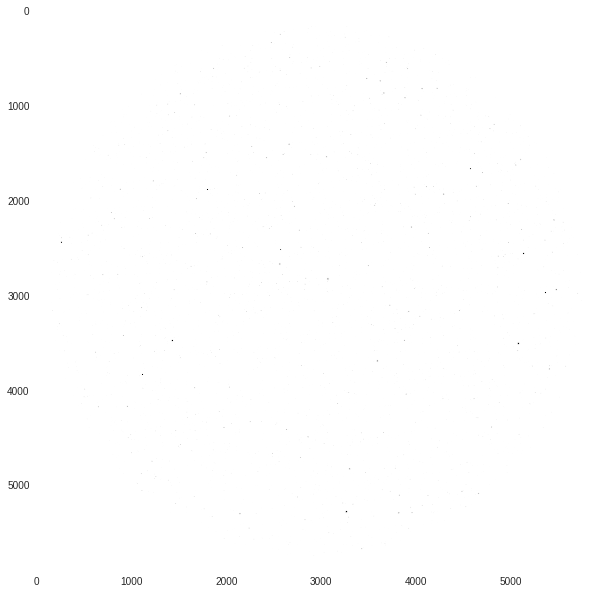

In [95]:
plt.figure(figsize = (10,10))

plt.imshow(mM -bkgM, cmap=cm.gray_r)